<a href="https://colab.research.google.com/github/DrFrank25/MD-analysis/blob/main/SASA_NMDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # --- Script RMSD com suavização Savitzky–Golay ---
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
from scipy.signal import savgol_filter

In [ ]:
# ===== Ajustes =====
SMOOTH_WINDOW = 11  # tamanho máximo da janela de suavização (ímpar)
POLY_ORDER = 2      # ordem do polinômio para Savitzky–Golay
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
FIGSIZE = (11, 6)
DPI = 1200
# Nomes para a legenda
NOMES_LEGENDA = ["Run 1", "Run 2", "Run 3",]
# ===================

In [ ]:
# Upload de arquivos
uploaded = files.upload()
if not uploaded:
    raise SystemExit("Nenhum arquivo carregado. Faça upload de arquivos .xvg.")


Saving sasa_1.xvg to sasa_1.xvg
Saving sasa_2.xvg to sasa_2.xvg
Saving sasa_3.xvg to sasa_3.xvg


In [ ]:
# Função para ler dados .xvg
def ler_xvg_from_bytes(content_bytes, encoding='utf-8'):
    s = content_bytes.decode(encoding, errors='replace')
    tempos, vals = [], []
    for linha in s.splitlines():
        linha = linha.strip()
        if not linha or linha.startswith(('#', '@')):
            continue
        partes = linha.split()
        if len(partes) >= 2:
            try:
                tempos.append(float(partes[0]))
                vals.append(float(partes[1]))
            except ValueError:
                continue
    return np.array(tempos), np.array(vals)

plt.figure(figsize=FIGSIZE)

<Figure size 1100x600 with 0 Axes>

<Figure size 1100x600 with 0 Axes>

Run 1:
  Média: 350.43 nm
  Desvio padrão: 6.6 nm

Run 2:
  Média: 349.06 nm
  Desvio padrão: 5.3 nm

Run 3:
  Média: 347.03 nm
  Desvio padrão: 6.3 nm



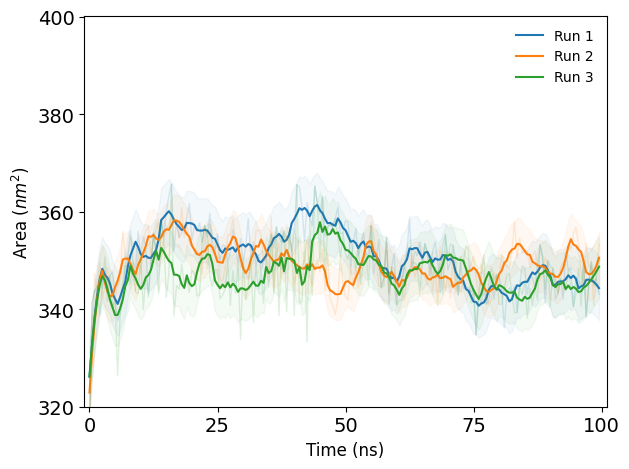

In [ ]:
# Loop pelos arquivos enviados
for i, (nome, content) in enumerate(uploaded.items()):
    tempo, rmsd = ler_xvg_from_bytes(content)

    if tempo.size == 0 or rmsd.size == 0:
        print(f"Aviso: '{nome}' sem dados válidos. Pulando.")
        continue

    # Ordena por tempo
    ordem = np.argsort(tempo)
    tempo = tempo[ordem]
    rmsd = rmsd[ordem]

    # --- Interpolação para uniformizar o eixo de tempo ---
    # Define um eixo de tempo comum (ex.: 0 até o máximo, com passo de 1 ns)
    tempo_comum = np.arange(0, np.nanmax(tempo), 0.5)  # ajuste o passo aqui

    # Interpola apenas os pontos válidos
    mask_valid_interp = np.isfinite(tempo) & np.isfinite(rmsd)
    rmsd_interp = np.interp(tempo_comum, tempo[mask_valid_interp], rmsd[mask_valid_interp])

    # Substitui as variáveis para usar no resto do código
    tempo = tempo_comum
    rmsd = rmsd_interp

    # Máscara de dados válidos
    mask_valid = np.isfinite(tempo) & np.isfinite(rmsd) & (tempo >= 0) & (rmsd >= 0)
    pontos_validos = np.sum(mask_valid)

    # Ajuste de janela para dados pequenos
    janela = min(SMOOTH_WINDOW, pontos_validos if pontos_validos > 3 else 1)
    if janela % 2 == 0:
        janela = max(5, janela - 1)  # janela precisa ser ímpar

    tempo_masked = np.where(mask_valid, tempo, np.nan)
    rmsd_masked = np.where(mask_valid, rmsd, np.nan)

    media = np.nanmean(rmsd_masked)
    desvio = np.nanstd(rmsd_masked)

    # Suavização Savitzky–Golay
    if pontos_validos >= 3 and janela > POLY_ORDER:
        smooth_valid = savgol_filter(
            rmsd_masked[mask_valid],
            window_length=janela,
            polyorder=POLY_ORDER,
            mode='interp'
        )
        smooth = np.full_like(rmsd_masked, np.nan)
        smooth[mask_valid] = smooth_valid
    else:
        smooth = rmsd_masked.copy()

    color = COLORS[i % len(COLORS)]


    # Nome da curva para legenda
    nome_curva = NOMES_LEGENDA[i] if i < len(NOMES_LEGENDA) else f"Run {i+1}"

    # Curva crua
    valid_raw = np.isfinite(tempo_masked) & np.isfinite(rmsd_masked)
    plt.plot(tempo_masked[valid_raw], rmsd_masked[valid_raw],
             linewidth=1.0, alpha=0.15, color=color)

    # Curva suavizada
    valid_smooth = np.isfinite(tempo_masked) & np.isfinite(smooth)
    plt.plot(tempo_masked[valid_smooth], smooth[valid_smooth],
             label=f"{nome_curva}")

    # Faixa ± desvio
    low = smooth[valid_smooth] + desvio
    high = smooth[valid_smooth] - desvio
    plt.fill_between(tempo_masked[valid_smooth], low, high, alpha=0.05, color=color)

    print(f"{nome_curva}:")
    print(f"  Média: {media:.2f} nm")
    print(f"  Desvio padrão: {desvio:.1f} nm\n")

    # Configuração dos eixos
    plt.xlabel("Time (ns)", fontsize=12)
    plt.ylabel("Area ($nm^2$)", fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=14)

    # Intervalo dos ticks
    plt.xlim(-1, 101)  # limite eixo X
    plt.ylim(320, 400.1)  # limite eixo Y
    plt.xticks(np.arange(0, 101, 25))     # de 0 a 105, passo 25
    plt.yticks(np.arange(320, 400.1, 20))  # de 0 a 1.01, passo 0.2

    # Lista de nomes desejados
    nomes_runs = ["Run 1", "Run 2", "Run 3",]


# Legenda personalizada
plt.legend(
    loc='upper right',
    fontsize=10,
    frameon=True,
    facecolor='white',
    edgecolor='white',
    fancybox=False,
    shadow=False
)

plt.grid(False)
plt.tight_layout()
# --- salvar e baixar a figura (no final do script, ANTES de plt.show()) ---
fig = plt.gcf()  # pega a figura atual (a que você acabou de plotar)
fig.tight_layout()
fig.canvas.draw()  # força a renderização no Colab
plt.show()


In [ ]:
# Salva figura em alta resolução com nome específico
fig.savefig(
    "SASA_NMDA.png",
    dpi=1200,
    bbox_inches='tight',
    transparent=False  # pode trocar para False se preferir fundo sólido
)

from google.colab import files
files.download("SASA_NMDA.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ======================
# Média geral das 3 runs (valores brutos)
# ======================

# === Estatísticas globais com dados brutos (a partir do upload) ===
todos_valores = []

for nome, content in uploaded.items():
    tempo, rmsd = ler_xvg_from_bytes(content)
    mask_valid = np.isfinite(rmsd) & (rmsd >= 0)
    if np.any(mask_valid):
        todos_valores.extend(rmsd[mask_valid])

todos_valores = np.array(todos_valores)

media_global = np.mean(todos_valores)
desvio_global = np.std(todos_valores)

print("\n=== Estatísticas da média geral (dados brutos) ===")
print(f"Média global: {media_global:.4f} nm")
print(f"Desvio padrão global: {desvio_global:.4f} nm")


=== Estatísticas da média geral (dados brutos) ===
Média global: 347.5745 nm
Desvio padrão global: 5.7846 nm
